# TDT4173 - Machine Learning
Names: Jacob Alexander Worsøe, Henrik August Søntvedt, Simen Øygarden Burgos

Student IDs: 544553, 543969, 543917

Team name: 5tabekk

Team number: 5

# Imports and setup

In [5]:
# Temporarily suppress FutureWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

# In module1.py
import sys
import os

# Get the absolute path of parent folder
current_dir = os.path.abspath("")
parent_dir = os.path.join(current_dir, os.pardir)

# Add to sys.path
sys.path.append(parent_dir)

import random
import catboost as cb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit, train_test_split

from abc import ABC, abstractmethod
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error
import statistics

### Set path to data (we have it in a "data" folder with data/A/*.parquet)

In [6]:
data_dir = './data/'

# Data loading and cleaning

In [7]:
###### TRAINING DATA ######
def get_training():
    """ gets full training data (duh) """

    train_a = pd.read_parquet(data_dir + 'A/train_targets.parquet')
    train_b = pd.read_parquet(data_dir + 'B/train_targets.parquet')
    train_c = pd.read_parquet(data_dir + 'C/train_targets.parquet')

    X_train_estimated_a = pd.read_parquet(data_dir + 'A/X_train_estimated.parquet')
    X_train_estimated_b = pd.read_parquet(data_dir + 'B/X_train_estimated.parquet')
    X_train_estimated_c = pd.read_parquet(data_dir + 'C/X_train_estimated.parquet')

    X_train_observed_a = pd.read_parquet(data_dir + 'A/X_train_observed.parquet')
    X_train_observed_b = pd.read_parquet(data_dir + 'B/X_train_observed.parquet')
    X_train_observed_c = pd.read_parquet(data_dir + 'C/X_train_observed.parquet')

    ret = pd.DataFrame()
    ret.set_index(pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['location', 'datetime']), inplace=True)
    ret.columns = pd.MultiIndex(levels=[[],[], []], codes=[[],[], []], names=['feature_type', 'minutes', 'feature_name'])


    # estimated data
    data_dict = {'A': X_train_estimated_a, 'B': X_train_estimated_b, 'C': X_train_estimated_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_calc', 'date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['estimated'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])

    # observed data
    data_dict = {'A': X_train_observed_a, 'B': X_train_observed_b, 'C': X_train_observed_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['observed'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])
        


    # # train data
    data_dict = {'B': train_b, 'C': train_c} # 'A': train_a, 

    out_temp = train_a.dropna().copy()
    out_temp.rename(columns={'time': 'datetime'}, inplace=True)
    out_temp.set_index('datetime', inplace=True)
    out_temp.columns = pd.MultiIndex.from_product([['y'], ['NA'], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

    out_temp.set_index(pd.MultiIndex.from_product([['A'], out_temp.index], names=['location', 'datetime']), inplace=True)

    for loc in data_dict:

        out_temp2 = data_dict[loc].dropna().copy()
        out_temp2.rename(columns={'time': 'datetime'}, inplace=True)
        out_temp2.set_index('datetime', inplace=True)
        out_temp2.columns = pd.MultiIndex.from_product([['y'], ['NA'], out_temp2.columns], names=['feature_type', 'minutes', 'feature_name'])

        out_temp2.set_index(pd.MultiIndex.from_product([[loc], out_temp2.index], names=['location', 'datetime']), inplace=True)

        out_temp = pd.concat([out_temp, out_temp2])

        # ret = ret.merge(out_temp, left_index=True, right_index=True, how='outer')
        # ret = pd.concat([ret, out_temp])
        

    ret = pd.merge(out_temp, ret, left_index=True, right_index=True, how='outer')

    return ret

def get_training_groupby_mean():
    return get_training().groupby(level = [0,2], axis = 1).mean()[['y', 'estimated', 'observed']]

def get_training_flattened():
    df = get_training_groupby_mean()

    df['estimated', 'weather_data_type'] = np.nan

    df['estimated', 'weather_data_type'] = np.where(df['observed', 'absolute_humidity_2m:gm3'].notna(),'observed', df['estimated', 'weather_data_type'])
    df['estimated', 'weather_data_type'] = np.where(df['estimated', 'absolute_humidity_2m:gm3'].notna(),'estimated', df['estimated', 'weather_data_type'])
    df.estimated = df.estimated.fillna(df.observed)

    df = df.drop(columns=['observed'], level=0)
    df.columns = df.columns.droplevel().tolist()
    df.reset_index(inplace=True)
    df.rename(columns={'datetime': 'ds', 'pv_measurement': 'y'}, inplace=True)
    # df['ENG_total_rad'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']
    
    return df[['location', 'ds', 'y', 'weather_data_type'] + [i for i in df.columns.tolist() if i not in ['location', 'ds', 'y', 'weather_data_type']]].copy()

"""
    Based on the EDA we clean the data training data for NAs in pv_measurements, make data the hourly average.
"""
def get_training_cleaned():
    df = get_training_flattened()

    df = df[
            ~((df.y != 0) & 
            (df.y == df.y.shift(-1)) &
            (df.y == df.y.shift(-2)))
        ].copy()

    df.dropna(axis=0, subset='y', inplace=True)

    return df

###### TESTING DATA ######
def get_testing():
    """ gets the feature estimates used for the forecast """

    X_test_estimated_a = pd.read_parquet(data_dir + 'A/X_test_estimated.parquet')
    X_test_estimated_b = pd.read_parquet(data_dir + 'B/X_test_estimated.parquet')
    X_test_estimated_c = pd.read_parquet(data_dir + 'C/X_test_estimated.parquet')

    ret = pd.DataFrame()
    ret.set_index(pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['location', 'datetime']), inplace=True)
    ret.columns = pd.MultiIndex(levels=[[],[], []], codes=[[],[], []], names=['feature_type', 'minutes', 'feature_name'])


    # estimated data
    data_dict = {'A': X_test_estimated_a, 'B': X_test_estimated_b, 'C': X_test_estimated_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_calc', 'date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['estimated'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])

    return ret

def get_testing_flattened():
    df = get_testing()
    df = df.groupby(level = [0,2], axis = 1).mean()[['estimated']]
    df.columns = df.columns.droplevel().tolist()
    df.reset_index(inplace=True)
    df.rename(columns={'datetime': 'ds'}, inplace=True)
    df['weather_data_type'] = 'estimated'
    return df[['location', 'ds', 'weather_data_type'] + [i for i in df.columns.tolist() if i not in ['location', 'ds', 'y', 'weather_data_type']]]

# Utils-functions for making the submittable file

In [17]:
###### UTILS FUNCTIONS ######
def y_pred_to_csv(file_name, df):
    df[['y_pred']].reset_index(drop=True).reset_index().rename(columns={'index': 'id', 'y_pred': 'prediction'}).to_csv("./submissions/" + file_name, index=False)

def make_submittable(file_name, model = None, model_dict = None):
    """
    model if same model used for all locations
    model dict if not

    model is instance of model (model = MetaModel())
    model dict uses location as key ({"A": MetaModel(), "B": MetaModel(), "C": MetaModel()})
    """

    df = get_training_cleaned()
    test = get_testing_flattened()
    ret = pd.DataFrame()
    
    for location in ['A', 'B', 'C']:
        temp_df = df[df['location']==location]
        temp_test = test[test['location']==location]

        if model is not None:
            m = model
        elif model_dict is not None:
            m = model_dict[location]
        else:
            raise ValueError("no model specified")
    
        m.train(temp_df)
        fcst = m.predict(temp_test)

        ret = pd.concat([ret, fcst])

    y_pred_to_csv(file_name, ret)

# Abstract Model-class
Definition of an abstract model class that all models inherit. This helped streamline production of models and make comparable testing-figures through the test-functions that all inheriting models use.

In [18]:
class MetaModel(ABC):     
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None

        return

    def test(self, df: pd.DataFrame, n_splits=5):
        """
            K-fold cross-validation, df must have y in it for testing against predictions
        """
        print(f"Testing {self.model_name}")
        column_names = df.columns.tolist()
        if 'y' not in column_names:
            raise Exception(f"Missing observed y in columns. Available are {column_names}")

        # This is unecessary because we already clean it when calling train
        # drop_y_with_na
        df = df.dropna(subset=['y'], inplace=False)

        MAE_values = []
        MSE_values = []

        # tscv = TimeSeriesSplit(n_splits=n_splits)
        kf =KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_index, test_index in kf.split(df):
            train_partition = df.iloc[train_index]
            valid_partition = df.iloc[test_index]

            self.train(train_partition)
            predictions = self.predict(valid_partition)
            
            y_true = valid_partition['y']
            y_pred = predictions['y_pred']

            MAE = mean_absolute_error(y_true, y_pred)
            MAE_values.append(MAE)

            MSE_values.append((y_pred - y_true).mean())

            print(f"Run {len(MAE_values)} MAE =", MAE)

        print("Mean Signed Error vals", MSE_values)
        average_mae = statistics.mean(MAE_values)
        print("MAE Vals: MEAN:", average_mae, 'ALL:' , MAE_values)
        
        return MAE_values
    
    @abstractmethod
    def preprocess(df: pd.DataFrame) -> pd.DataFrame:
        """
            Takes in single-index (datetime as index) df, and returns df with only desired features
        """    
        pass
    
    @abstractmethod
    def train(df: pd.DataFrame):
        """

        """
        pass

    @abstractmethod
    def predict(df: pd.DataFrame):
        """
            Runs trained model on on input df, preprocessing the df first and then returns datetime and y_pred
        """
        pass

# CatBoost

In [19]:
class CatBoostHenrik(MetaModel):
    
    def __init__(self, features=None, random_state=42):
        super().__init__("CatBoost")

        self.random_state = random_state

        # Our CatBoost model supports using internal features. But, if you look at 
        # CatComposite you will see that models are passed in for each model.
        if(features):
            self.features = features
        else:
            self.features = []
            self.features.extend(['sample_importance',
                                'dayofyear',
                                'hour',
                                'total_rad_1h:J',
                                'is_day:idx',
            'absolute_humidity_2m:gm3',
            'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
            'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
            'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
            'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
            'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
            'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
            'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
            'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
            'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
            'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
            't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
            'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
            'wind_speed_w_1000hPa:ms'])

    def preprocess(self, df: pd.DataFrame):
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns        
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

        # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        # ! CatBoost doesn't use this for training-emphasis, but it needs to be made to avoid an error !
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        # Make total radiation feature
        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day, month, and day-of-year to make them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['month'] = temp_df['ds'].dt.month
        temp_df['month'] = (np.sin(2 * np.pi * (temp_df['month'])/ 12) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO CatBoost
        temp_df.fillna(0, inplace=True)
        #####################################################################################

        # Dropping features that aren't needed from the DF
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df

    def train(self, df):
        temp_df = self.preprocess(df)

        # Separate features and target
        X = temp_df.drop('y', axis=1, inplace=False).copy().values
        y = temp_df['y'].copy().values

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=self.random_state)

        # Parameters found through grid-search and some manual tuning (CatBoostRegressor.grid_search())
        params = {
            'objective': "MAE",
            'learning_rate': 0.02,
            'depth': 6,
            'iterations': 8000,
            'logging_level': 'Silent',
            'l2_leaf_reg': 5
        }

        # Set-up model with above features
        self.model = cb.CatBoostRegressor(**params)
        
        self.model.fit(
             X_train,
             y_train,
             verbose=True,
             eval_set=(X_test, y_test),
        )

    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        features = [col for col in df.columns if col != 'y']
        X = df[features].values
        y_preds = self.model.predict(X)

        # Set all negative predictions to 0
        y_preds = np.maximum(y_preds, 0)

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df

# CatBoost Composite
This model takes an arithmetic average of 20 CatBoost models. 

To make the individual CatBoost models slightly different and less prone to overfitting, we assign the models slightly different features. The features that were found to have particular importance in the EDA, were used as the common features. All other features, except for those removed as described in the cleaning and preprocessing were randomly assigned. Through experimentation we found that this composite model performed best when each individual model randomly selected 90% of the models in the random-pool.

In addition to this, the models have different train-test splits by being provided different random-seeds.

In [20]:
class CatCompositeHenrik(MetaModel):
    
    def __init__(self, num_models=20):
        super().__init__("CatComposite Henrik")

        self.num_models = num_models

        # Set of features all models will have in common, selected
        # those that have had high importance in prior trainings.
        self.common_features = ['sample_importance', 'is_estimated','dayofyear',
                                'is_day:idx',
                             'hour', 'month',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
        # The set of features from which each models samples at random
        self.random_features = ['absolute_humidity_2m:gm3',
                                'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                                'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                                'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
                                'direct_rad_1h:J', 'fresh_snow_3h:cm',
                                'precip_5min:mm','precip_type_5min:idx', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                                'sfc_pressure:hPa','snow_water:kgm2',
                                'super_cooled_liquid_water:kgm2',
                                't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                                'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
             
    def preprocess(self, df: pd.DataFrame):
        # All preprocessing is done by the individual CatBoost models, so nothing here.
        return df.copy()
    
    def train(self, df: pd.DataFrame):
        num_models = self.num_models

        # How many of the features to be random, this gives some variations in all data and reduces overfitting.
        # Each model picks 90% of the features from the "random_features" pool. 90% was found through experimenting
        # and have given the best results.
        num_rand_features = round(len(self.random_features) * 0.9)

        # Manually set random_states to be used for each models for reproducability
        random_states = [i for i in range(33, 33 + num_models)]

        # Duplicate rows for months 5, 6, and 7 to overfit learning for the months we intend to predict
        df = df.copy()
        df['month'] = df['ds'].dt.month

        selected_months = df[(df['month'] == 5) | (df['month'] == 6) | (df['month'] == 7)].copy()
        train_df = pd.concat([df, selected_months], ignore_index=True)

        # Set-up models
        features = dict()
        self.models = dict()

        for i in range(num_models):
            random.seed(random_states[i])
            temp_rand_features = random.sample(self.random_features, num_rand_features)
            features[i] = self.common_features + temp_rand_features
            self.models[f'CATBOOST_{i}'] = CatBoostHenrik(features = features[i], random_state=random_states[i])

        # Train each model
        for key in self.models:
            print("Training model", key)
            self.models[key].train(train_df)     
    
    def predict(self, df):
        all_preds = None
        out_df = None

        # Get predictions from all the sub-models
        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

        # Take equally weighted average of models
        out_np = all_preds.mean(axis=1)

        return pd.DataFrame(out_np, columns=['y_pred'])


# K-Fold Cross-validation for each location

In [21]:
"""
df = ml.data.get_training_cleaned()

for location in ['A', 'B', 'C']:
    print(f"###############  LOCATION {location} ###############")
    df_location = df[df['location'] == location]
    
    cch = CatCompositeHenrik()
    cch.test(df_location)
"""

'\ndf = ml.data.get_training_cleaned()\n\nfor location in [\'A\', \'B\', \'C\']:\n    print(f"###############  LOCATION {location} ###############")\n    df_location = df[df[\'location\'] == location]\n    \n    cch = CatCompositeHenrik()\n    cch.test(df_location)\n'

# Make Submittable

In [22]:
# Generate submittable
make_submittable("CatComposite_new_features_x20_lr0_03_iters8000_nothing_random_short_notebook.csv",
                           model=CatCompositeHenrik(num_models=20))

Training model CATBOOST_0
Training model CATBOOST_0
Training model CATBOOST_0


# Model Interpretation

### Feature Importance
Below we list out the most important features found by CatBoost. The most important features are reflected in the common feature-set that each of the individual CatBoost models use. We should note that there is some variation in the found importance, so the selected common features reflect what we have seen historically (the example below is only of a single CatBoost model for each location). The important features reflect what we thought out in the initial analysis.

The feature 'total_rad_1h:J' which we created as a sum of the direct and diffuse radiation consistently lists among the top 5, reflecting its predictive power.

###############  LOCATION A ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    20.918351                 direct_rad:W
      1           6    11.263992               total_rad_1h:J
      2          26    10.475586              clear_sky_rad:W
      3          32     8.221069        clear_sky_energy_1h:J
      4          10     7.270952      effective_cloud_cover:p
      5           7     6.055241              sun_elevation:d
      6           4     4.528881                         hour
      7          15     3.851120                diffuse_rad:W
      8          24     2.566700                 visibility:m
      9           2     2.512448                    dayofyear
      10         23     2.413328          total_cloud_cover:p
      11          8     2.135436                sun_azimuth:d
      12         19     1.876579          wind_speed_u_10m:ms
      13         30     1.773920         ceiling_height_agl:m
      14         20     1.642726          wind_speed_v_10m:ms
      15         17     1.636062             sfc_pressure:hPa
      16         22     1.485150            wind_speed_10m:ms
      17         18     1.484327  relative_humidity_1000hPa:p
      18         12     1.442543             cloud_base_agl:m
      19         27     1.216118          air_density_2m:kgm3
      20         13     1.026497                  t_1000hPa:K
      21         14     0.841605               dew_point_2m:K
      22         33     0.752790     absolute_humidity_2m:gm3
      23         31     0.746880               precip_5min:mm
      24          5     0.478238                        month
      25         28     0.472720         precip_type_5min:idx
      26         11     0.438142              snow_water:kgm2
      27          0     0.163842            sample_importance
      28         16     0.161888              rain_water:kgm2
      29          9     0.085472             is_in_shadow:idx
      30          1     0.031299                 is_estimated
      31          3     0.024407                   is_day:idx
      32         25     0.005254             fresh_snow_3h:cm
      33         29     0.000438              dew_or_rime:idx

###############  LOCATION B ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    17.436544                 direct_rad:W
      1          26    14.688291              clear_sky_rad:W
      2           7     8.196960              sun_elevation:d
      3           6     7.532951               total_rad_1h:J
      4          10     5.524847      effective_cloud_cover:p
      5           2     5.491767                    dayofyear
      6          32     5.101848        clear_sky_energy_1h:J
      7          15     4.352513                diffuse_rad:W
      8           8     3.297496                sun_azimuth:d
      9          13     2.711329                  t_1000hPa:K
      10         17     2.559483             sfc_pressure:hPa
      11         12     2.380967             cloud_base_agl:m
      12         18     2.320241  relative_humidity_1000hPa:p
      13         24     2.132842                 visibility:m
      14         19     1.952739          wind_speed_u_10m:ms
      15          5     1.845136                        month
      16          4     1.727809                         hour
      17         14     1.597631               dew_point_2m:K
      18         20     1.456389          wind_speed_v_10m:ms
      19         22     1.196714            wind_speed_10m:ms
      20         23     1.137986          total_cloud_cover:p
      21         30     1.135441         ceiling_height_agl:m
      22         27     1.103036          air_density_2m:kgm3
      23         33     0.901953     absolute_humidity_2m:gm3
      24         11     0.614508              snow_water:kgm2
      25         31     0.432329               precip_5min:mm
      26         28     0.408603         precip_type_5min:idx
      27          1     0.280557                 is_estimated
      28          0     0.241577            sample_importance
      29          9     0.123436             is_in_shadow:idx
      30         16     0.101589              rain_water:kgm2
      31          3     0.013639                   is_day:idx
      32         25     0.000616             fresh_snow_3h:cm
      33         29     0.000235              dew_or_rime:idx

###############  LOCATION C ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    18.407935                 direct_rad:W
      1           6    10.714059               total_rad_1h:J
      2          32    10.243106        clear_sky_energy_1h:J
      3          26     9.843218              clear_sky_rad:W
      4           7     8.371733              sun_elevation:d
      5          13     5.362713                  t_1000hPa:K
      6           2     3.690887                    dayofyear
      7          15     3.468257                diffuse_rad:W
      8          10     3.103447      effective_cloud_cover:p
      9          17     2.541057             sfc_pressure:hPa
      10         18     2.285165  relative_humidity_1000hPa:p
      11         27     2.022401          air_density_2m:kgm3
      12         19     1.838124          wind_speed_u_10m:ms
      13         14     1.722178               dew_point_2m:K
      14          4     1.626021                         hour
      15         24     1.554912                 visibility:m
      16         22     1.517729            wind_speed_10m:ms
      17         20     1.497585          wind_speed_v_10m:ms
      18          8     1.299596                sun_azimuth:d
      19         33     1.265144     absolute_humidity_2m:gm3
      20          5     1.143674                        month
      21         23     1.117529          total_cloud_cover:p
      22         12     1.070573             cloud_base_agl:m
      23         30     1.025613         ceiling_height_agl:m
      24          0     0.840484            sample_importance
      25         11     0.521384              snow_water:kgm2
      26         28     0.520054         precip_type_5min:idx
      27         31     0.491201               precip_5min:mm
      28          1     0.393564                 is_estimated
      29          9     0.311747             is_in_shadow:idx
      30         16     0.165475              rain_water:kgm2
      31          3     0.014426                   is_day:idx
      32         25     0.008494             fresh_snow_3h:cm
      33         29     0.000512              dew_or_rime:idx

### Fluctuations
In the predicted y shown below we see that the daily fluctuations are present as is expected. This is the case for each of the locations.
#### Location A
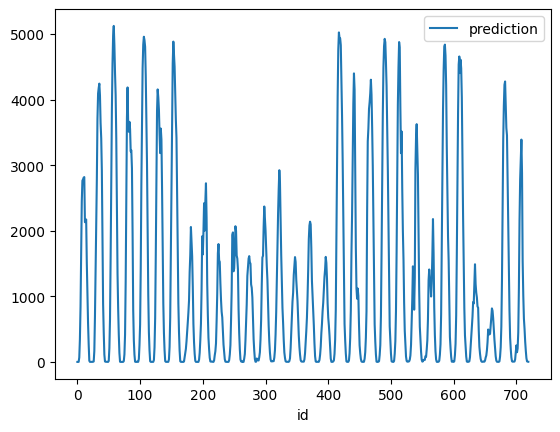

#### Location B
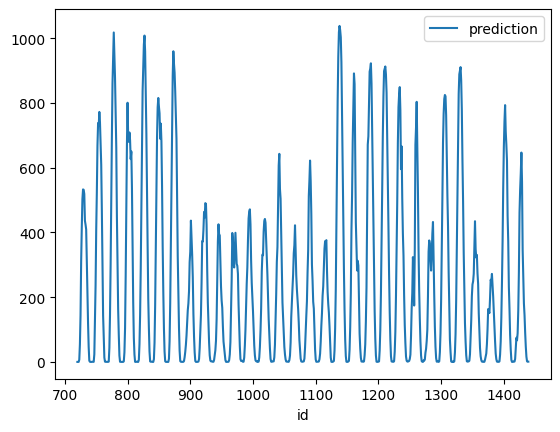

#### Location C
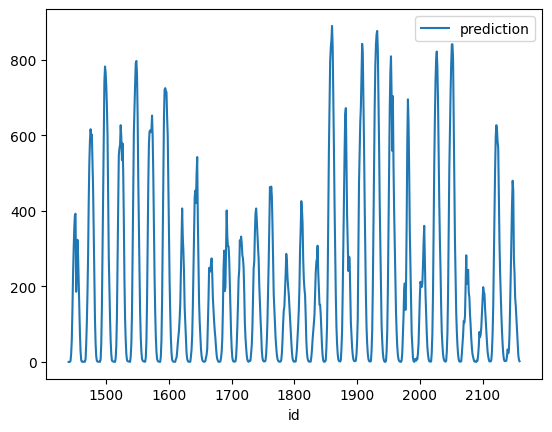


<Axes: xlabel='id'>

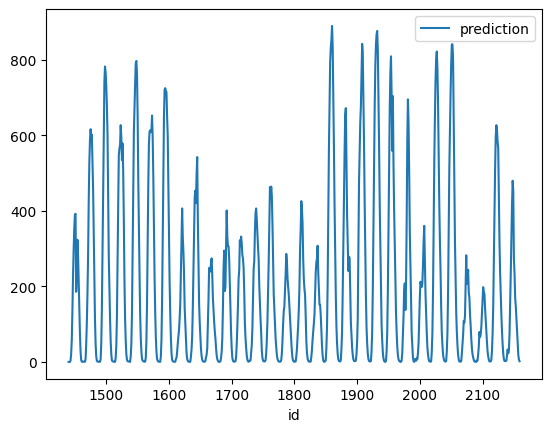

In [28]:
df_out = pd.read_csv('./submissions/CatComposite_new_features_x20_lr0.03_iters8000_nothing_random.csv')
df_out[(df_out['id'] >= 1440)].plot(x='id', y='prediction')